# Prepossessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import NaN
plt.style.use('seaborn-white')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 26}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.tick_params(labelsize=22)

import requests
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen as uReq
import urllib.request
import re
from re import sub

import math
import requests 
import json
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew  

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from bs4 import BeautifulSoup
from requests import get
from pandas import DataFrame
from tabulate import tabulate
import dtale

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium import webdriver

import itertools
from itertools import chain
from IPython.core.display import HTML

import matplotlib.pyplot as plt
from decimal import Decimal
import datetime

import shapely
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import nearest_points
import geopandas as gpd
import descartes
import matplotlib.pyplot as plt
import shapefile as shp

from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

import warnings
%matplotlib inline

/Users/joje/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Takes a lot of time to run!

In [2]:
#######################################################
#################### LOAD DATA ########################
#######################################################
# Load data
df = pd.read_csv('Endeligt data/df_done.csv')
df = df.drop(columns=['PriceReduction', 'HasMultipleLevels'])
df['SaleDate'] = pd.to_datetime(df['SaleDate'],format='%Y-%m-%d', errors='coerce')
df['YearSold'] = df['SaleDate'].dt.year
df['MonthSold'] = df['SaleDate'].dt.month
df['BuildAge'] = df['YearSold']  - df['YearBuilt']
df.BuildAge[df['BuildAge'] < 0]  == 0
df['RemodAfterBuild'] =  df['YearRemodAdd'] - df['YearBuilt']
df = df.drop(columns=['YearBuilt', 'YearRemodAdd'])


def surroundings(df, num):
    dateofsale = df.SaleDate.iloc[num]
    # Only consider houses with salesdate before actual sale
    dff = df[df.SaleDate < dateofsale]
    dff['SquareMetrePrice'] = dff['SalePrice'] / dff['WeightedFloorArea']
    # Only consider houses nearby
    dff = dff[(dff.Latitude < df.Latitude.iloc[num] +0.01) & (dff.Latitude > df.Latitude.iloc[num] - 0.01)]
    dff = dff[(dff.Longitude < df.Longitude.iloc[num] +0.01) & (dff.Longitude > df.Longitude.iloc[num] - 0.01)]
    # Only consider same house type
    dff = dff[dff.Type == df.Type.iloc[num]]
    # Only consider houses with a age +- 10 years from actual dage
    dff = dff[(dff.BuildAge < df.BuildAge.iloc[num] +5) & (dff.BuildAge > df.BuildAge.iloc[num] - 5)]
    # Only consider building with same size
    #dff = dff[dff.FloorAreaBuilding == df.FloorAreaBuilding.iloc[num]]
    #dff = dff[dff.FloorsTotal == df.FloorsTotal.iloc[num]]
    # Calculate the squaremetre price where we take the priceindex into account
    indexofsale = df.PriceIndex.iloc[num]
    dff['SquareMetrePrice'] = dff['SquareMetrePrice'] * (indexofsale / dff['PriceIndex'])
    # Return the estimated sales price based on the surrounding houses salesprice
    return np.mean(dff['SquareMetrePrice'])


lst = []
for i in tqdm(range(0, len(df))):
    lst.append(surroundings(df, i))

    
df['Neighbors'] = pd.DataFrame(lst, columns=['Neighbors'])

df.to_csv('Endeligt data/df_with_NeighborsInfo.csv', index = False)


In [3]:
df = pd.read_csv('Endeligt data/df_with_NeighborsInfo.csv')


# Split into y and X 
y_save = df.loc[:, df.columns.isin(['GeomaticAVMPrice', 'AskingPrice', 'TurnoverTime', 'OfferingEnd', 'OfferingStart', 'SaleDate', 'Time', 'ValDate', 'LandValue', 'TaxableValue', 'Type'])]
y = df.loc[:, df.columns.isin(['SalePrice'])]
X_save = df.loc[:, df.columns.isin(['LinkGeo', 'LinkBoligsiden', 'Address'])]

#X = df.loc[:, ~df.columns.isin(['PriceHouse', 'PriceFlat','LinkGeo', 'LinkBoligsiden', 'Address', 'Lokation', 'Quarter', 'Year','YearQuarter','SalePrice', 'AskingPrice', 'GeomaticAVMPrice', 'TurnoverTime', 'OfferingEnd', 'OfferingStart', 'SaleDate', 'Time', 'ValDate', 'Latitude', 'Longitude', 'TaxableValue', 'LandValue'])]
X = df.loc[:, ~df.columns.isin(['Address', 'Latitude', 'Longitude', 'LinkGeo', 'LinkBoligsiden','OfferingEnd', 'OfferingStart',
                                'Quarter','Year','YearQuarter',
                                'SalePrice','AskingPrice', 'GeomaticAVMPrice', 'TaxableValue', 'LandValue', 'SaleDate', 'ValDate', 'TurnoverTime'])]


df_new = pd.concat([y, X], axis=1)


In [4]:
dtale.show(df_new)

### Correlations - numeric variables 

61


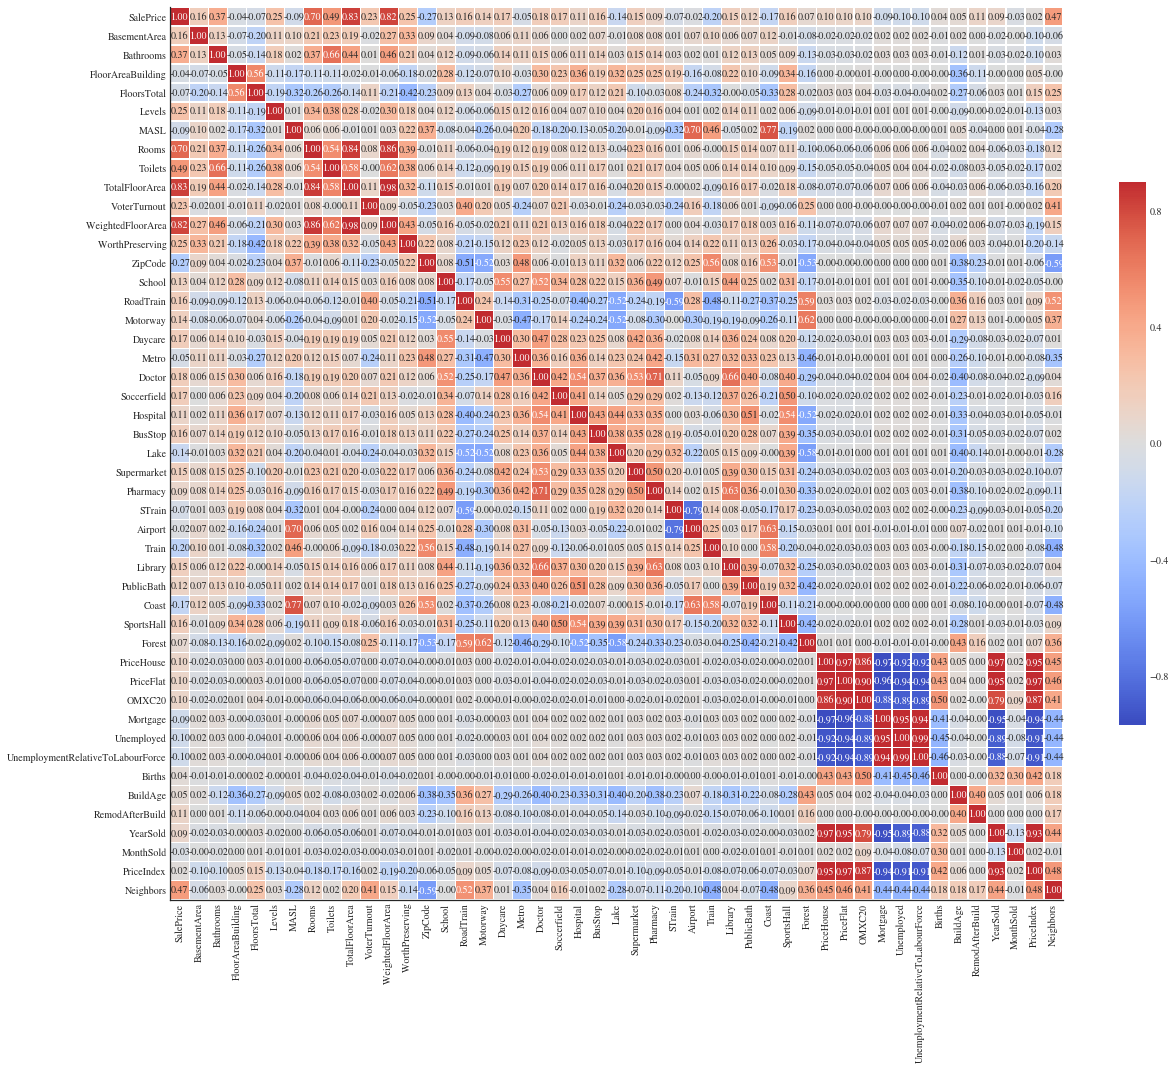

In [5]:
# Dtypes
categorical_df = df_new.select_dtypes(include=['object'])
numerical_df = df_new.select_dtypes(include=['float64', 'int64'])
print(categorical_df.shape[1]+numerical_df.shape[1])

# Heat map all numeric variables
corr_dist = numerical_df.corr(method='pearson')
g_dist = sns.heatmap(corr_dist,  vmax=0.9, center=0, xticklabels=True, yticklabels=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g_dist.figure.set_size_inches(20,20)
plt.show()

In [6]:
corr_dist = numerical_df.corr(method='pearson')
corr_branches_list = (corr_dist.where(np.triu(np.ones(corr_dist.shape), k=1).astype(np.bool))
                      .stack().sort_values(ascending=False))
corr_branches_list.head(15) 
corr_branches_list.tail(15)

corr_branches_list

Unemployed                         UnemploymentRelativeToLabourForce    0.985138
TotalFloorArea                     WeightedFloorArea                    0.980678
PriceHouse                         PriceFlat                            0.974801
                                   YearSold                             0.970257
PriceFlat                          PriceIndex                           0.967786
                                   YearSold                             0.953869
Mortgage                           Unemployed                           0.951573
PriceHouse                         PriceIndex                           0.947232
Mortgage                           UnemploymentRelativeToLabourForce    0.939962
YearSold                           PriceIndex                           0.926851
PriceFlat                          OMXC20                               0.895466
OMXC20                             PriceIndex                           0.865454
PriceHouse                  

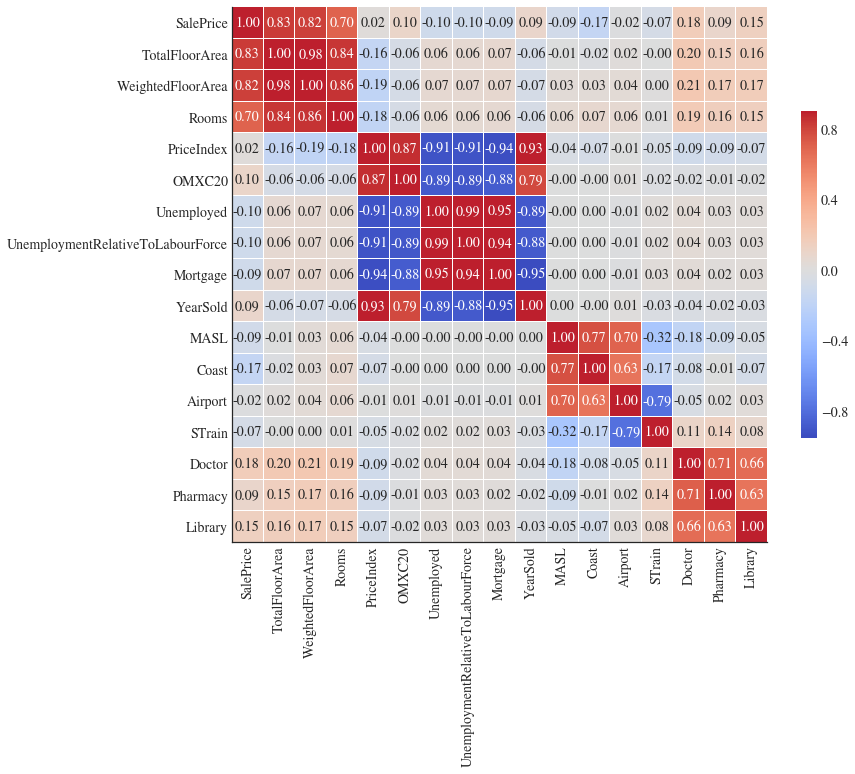

In [7]:
# All over abs(0.75)

most_corr = ['SalePrice', 'TotalFloorArea', 'WeightedFloorArea', 'Rooms', 'PriceIndex', 'OMXC20', 'Unemployed', 'UnemploymentRelativeToLabourForce', 'Mortgage', 'YearSold','MASL', 'Coast',  'Airport', 'STrain', 'Doctor', 'Pharmacy', 'Library']
plt.rcParams['font.size'] = 14

# Heast map most correlated
corr_dist = df_new[most_corr].corr(method='pearson')

g_dist = sns.heatmap(corr_dist,  vmax=0.9, center=0, xticklabels=True, yticklabels=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()

g_dist.figure.set_size_inches(12,12)
plt.show()

In [8]:
# Check dublicates

#df = pd.read_csv('Endeligt data/df_NeighborsInfoo.csv').iloc[:,1:]
#duplicateRowsDF = df[df.Address.duplicated()]


## Start from here

In [9]:
###################################################################
############ Take action - remove correlated variables ############
###################################################################

df = pd.read_csv('Endeligt data/df_with_NeighborsInfo.csv')
print(df.shape)

# Add YearSold and MonthSold
# Add BuildAge and RemodAfterBuild and remove YearBuilt and YearRemodAdd

y_save = df.loc[:, df.columns.isin(['GeomaticAVMPrice', 'AskingPrice', 'TurnoverTime', 'OfferingEnd', 'OfferingStart', 'SaleDate', 'Time', 'ValDate', 'LandValue', 'TaxableValue', 'Type'])]
y = df.loc[:, df.columns.isin(['SalePrice'])]
X_save = df.loc[:, df.columns.isin(['LinkGeo', 'LinkBoligsiden', 'Address'])]

df = df.loc[:, ~df.columns.isin(['Address', 'Latitude', 'Longitude', 'LinkGeo', 'LinkBoligsiden','OfferingEnd', 'OfferingStart',
                                 'Quarter','Year','YearQuarter',
                                 'PriceFlat', 'PriceHouse',
                                 'AskingPrice', 'GeomaticAVMPrice', 'TaxableValue', 'LandValue', 'SaleDate', 'ValDate', 'TurnoverTime'])]
print(df.shape)
df.columns

(35702, 78)
(35702, 59)


Index(['BasementArea', 'Bathrooms', 'BurglaryRisk', 'CloudburstRisk',
       'EnergyLabel', 'FloorAreaBuilding', 'FloorsTotal', 'HeatSource',
       'Kitchen', 'LargestParty', 'Levels', 'MASL', 'NoiseMeasurement',
       'OuterWallMat', 'RadonRisk', 'Roofing', 'Rooms', 'SalePrice', 'Toilets',
       'TotalFloorArea', 'Type', 'TypeHouse', 'VoteDistrict', 'VoterTurnout',
       'WeightedFloorArea', 'WorthPreserving', 'ZipCode', 'City', 'School',
       'RoadTrain', 'Motorway', 'Daycare', 'Metro', 'Doctor', 'Soccerfield',
       'Hospital', 'BusStop', 'Lake', 'Supermarket', 'Pharmacy', 'STrain',
       'Airport', 'Train', 'Library', 'PublicBath', 'Coast', 'SportsHall',
       'Forest', 'OMXC20', 'Mortgage', 'Unemployed',
       'UnemploymentRelativeToLabourForce', 'Births', 'BuildAge',
       'RemodAfterBuild', 'YearSold', 'MonthSold', 'PriceIndex', 'Neighbors'],
      dtype='object')

In [10]:
###################################################################
######################## Drop some variables ######################
###################################################################

# TotalFloorArea because correlation with WeightedFloorArea 
# Change the two variables PriceFlat and PriceHouse into once by conditioning on type - see above
# MASL vs coast - coast is more important
# Pharmacy vs. Doctor - doctor more important
# Strain vs. airport - airport not that important
# Drop YearSold - financial data covers that

df = df.drop(columns=['TotalFloorArea', 'Mortgage', 'YearSold', 'UnemploymentRelativeToLabourForce', 'MASL', 'Pharmacy'])
#df = df.drop(columns=['PriceIndex'])

In [11]:
df['ZipCode'].value_counts()

# Consider adding the zipcode in ranges
bins = [0,     1100,        1200,       1300,        1400,        1450,        1500,       1600,         1700,       1800,        1850,      1900,        2000,  2001,   2101,  2151,  2201,  2301,   2401,  2451,   2501,   2701,  2721]
names = ['<1100', '1100-1200', '1200-1300', '1300-1400','1400-1450', '1450-1500', '1500-1600', '1600-1700', '1700-1800', '1800-1850','1850-1900','1900-2000','2000','2100','2150','2200','2300', '2400', '2450', '2500', '2700', '2720']
d = dict(enumerate(names,1))
df['ZipCode_range'] = np.vectorize(d.get)(np.digitize(df['ZipCode'],bins))
df['ZipCode_range'] = df.ZipCode_range.astype('category')

df = df.drop(columns=['ZipCode'])


In [12]:
df.Neighbors.isnull().sum()
df.shape

(35702, 53)

In [13]:
###################################################################
######################### Show correlations #######################
###################################################################

# Dtypes df_new
categorical_df = df.select_dtypes(include=['object'])
categorical_cols_df = df.columns[df.dtypes==object].tolist()
numerical_df = df.select_dtypes(include=['float64', 'int64'])
numerical_cols_df = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(categorical_df.shape[1]+numerical_df.shape[1])
print(numerical_df.shape[1])
corr_dist = numerical_df.corr()
corr_branches_list = (corr_dist.where(np.triu(np.ones(corr_dist.shape), k=1).astype(np.bool))
                      .stack().sort_values(ascending=False))

corr_branches_list

52
38


OMXC20             PriceIndex           0.865454
Rooms              WeightedFloorArea    0.856489
SalePrice          WeightedFloorArea    0.817989
Rooms              SalePrice            0.699843
Doctor             Library              0.664998
Bathrooms          Toilets              0.662131
Airport            Coast                0.634466
Toilets            WeightedFloorArea    0.618248
Motorway           Forest               0.617509
RoadTrain          Forest               0.590830
Train              Coast                0.582228
FloorAreaBuilding  FloorsTotal          0.557373
School             Daycare              0.548703
Doctor             Hospital             0.542632
Rooms              Toilets              0.541283
Hospital           SportsHall           0.539941
Doctor             Supermarket          0.531765
RoadTrain          Neighbors            0.519203
School             Doctor               0.515499
Hospital           PublicBath           0.511683
OMXC20             B

In [14]:
#most_corr = ['SalePrice', 'Mortgage', 'PriceIndex','OMXC20', 'RoadTrain', 'STrain', 
#            'AvgRoomSize', 'WeightedFloorArea', 'Doctor',
#            'ToiletsBathrooms', 'ToiletsPerRoom', 'Bathrooms']


In [15]:
#import pandas as pd
#import numpy as np
#from patsy import dmatrices
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each numeric X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(var_num.values, i) for i in range(var_num.shape[1])]
#vif["features"] = var_num.columns

#vif

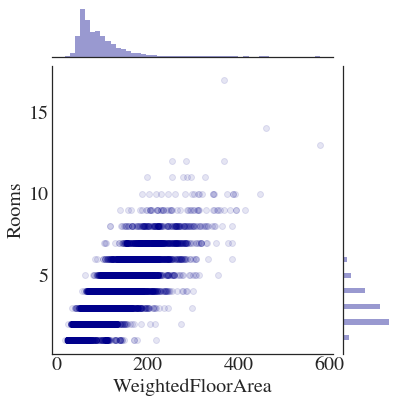

In [16]:
# Rooms and WeightedFloorArea
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 20

#plt.style.use('ggplot')
sns.jointplot(x="WeightedFloorArea", y="Rooms", 
              data=df, alpha = 0.1, color='darkblue')
#plt.xlabel('WeightedFloorArea')
#plt.ylabel('Rooms')
plt.show()

### Embedding of categorical variables

In [17]:
df_new_dummies = df.copy()
#df_new_dummies.select_dtypes(include=['object']).columns

##################################################
################### Nominal ######################
##################################################

categorical_columns_nominal = ['HeatSource','LargestParty', 'ZipCode_range','City','OuterWallMat','Type','VoteDistrict','TypeHouse','Roofing']

# FIX encoding:
df_new_dummies = pd.get_dummies(df_new_dummies, prefix=categorical_columns_nominal, columns = categorical_columns_nominal)

df_new_dummies.shape

(35702, 181)

In [18]:
dtale.show(df_new_dummies, ignore_duplicate=True)

In [19]:
##################################################
################### Ordinal ######################
##################################################

categorical_columns_ordinal = ['BurglaryRisk','CloudburstRisk','EnergyLabel','Kitchen','NoiseMeasurement','RadonRisk','WorthPreserving']

df['BurglaryRisk'].value_counts()
ordered_BurglaryRisk = ['lav','mellem','høj','meget høj']
df['BurglaryRisk'] = df.BurglaryRisk.astype('category').cat.set_categories(ordered_BurglaryRisk, ordered = True)

df['CloudburstRisk'].value_counts()
ordered_CloudburstRisk = ['er lav risiko','kan være risiko','er høj risiko']
df['CloudburstRisk'] = df.CloudburstRisk.astype('category').cat.set_categories(ordered_CloudburstRisk, ordered = True)

df['EnergyLabel'].value_counts()
ordered_EnergyLabel = ['A','B','C','D','E','F','G','Fredet']
df['EnergyLabel'] = df.EnergyLabel.astype('category').cat.set_categories(ordered_EnergyLabel, ordered = True)

df['Kitchen'].value_counts()
ordered_Kitchen= ['Eget køkken (med afløb og kogeinstallation)',
                  'Fast kogeinstallation i værelse eller på gang',
                  'Adgang til fælles køkken',
                  'Ingen fast kogeinstallation']
df['Kitchen'] = df.Kitchen.astype('category').cat.set_categories(ordered_Kitchen, ordered = True)

df['NoiseMeasurement'].value_counts()
ordered_NoiseMeasurement = ['Ingen trafikstøj','55-60 dB','60-65 dB','65-70 dB','70-75 dB','over 75 dB']
df['NoiseMeasurement'] = df.NoiseMeasurement.astype('category').cat.set_categories(ordered_NoiseMeasurement, ordered = True)

df['RadonRisk'].value_counts()
ordered_RadonRisk = ['Meget lav','lav','medium','høj','meget høj']
df['RadonRisk'] = df.RadonRisk.astype('category').cat.set_categories(ordered_RadonRisk, ordered = True)

df['WorthPreserving'].value_counts()
ordered_WorthPreserving = [0, 9, 8, 7, 6, 5, 4, 3, 2, 1]
df['WorthPreserving'] = df.WorthPreserving.astype('category').cat.set_categories(ordered_WorthPreserving, ordered = True)

# FIX ranking:
for i in categorical_columns_ordinal:
    df_new_dummies[i],unique = pd.factorize(df_new_dummies[i], sort=True)

df_new_dummies.shape

(35702, 181)

In [20]:
with pd.option_context('display.max_colwidth', -1): 
    display(HTML(df_new_dummies.head(100).to_html()))

,BasementArea,Bathrooms,BurglaryRisk,CloudburstRisk,EnergyLabel,FloorAreaBuilding,FloorsTotal,Kitchen,Levels,NoiseMeasurement,RadonRisk,Rooms,SalePrice,Toilets,VoterTurnout,WeightedFloorArea,WorthPreserving,School,RoadTrain,Motorway,Daycare,Metro,Doctor,Soccerfield,Hospital,BusStop,Lake,Supermarket,STrain,Airport,Train,Library,PublicBath,Coast,SportsHall,Forest,OMXC20,Unemployed,Births,BuildAge,RemodAfterBuild,MonthSold,PriceIndex,Neighbors,"HeatSource_Centralvarme fra eget anlæg, et-kammer fyr","HeatSource_Elovne, elpaneler",HeatSource_Fjernvarme/blokvarme (radiatorsystemer el. varmluftanlæg),HeatSource_Gasradiator,HeatSource_Ingen varmeinstallation,"HeatSource_Ovne (kakkelovne, kamin, brændeovne o.l.)",HeatSource_Varmepumpe,LargestParty_enhedslisten,LargestParty_radikale,LargestParty_socialdemokratiet,LargestParty_venstre,ZipCode_range_1100-1200,ZipCode_range_1200-1300,ZipCode_range_1300-1400,ZipCode_range_1400-1450,ZipCode_range_1450-1500,ZipCode_range_1500-1600,ZipCode_range_1600-1700,ZipCode_range_1700-1800,ZipCode_range_1800-1850,ZipCode_range_1850-1900,ZipCode_range_1900-2000,ZipCode_range_2000,ZipCode_range_2100,ZipCode_range_2150,ZipCode_range_2200,ZipCode_range_2300,ZipCode_range_2400,ZipCode_range_2450,ZipCode_range_2500,ZipCode_range_2700,ZipCode_range_2720,ZipCode_range_<1100,City_Brønshøj,City_Frederiksberg,City_Frederiksberg C,City_København K,City_København N,City_København NV,City_København S,City_København SV,City_København V,City_København Ø,City_Nordhavn,City_Valby,City_Vanløse,OuterWallMat_Andet materiale,OuterWallMat_Betonelementer (etagehøje betonelementer),OuterWallMat_Bindingsværk (med udvendigt synligt træværk),OuterWallMat_Fibercement (asbestfri),OuterWallMat_Glas,"OuterWallMat_Letbeton (lette bloksten, gasbeton)",OuterWallMat_Metalplader,"OuterWallMat_Mursten (tegl, kalksten, cementsten)",OuterWallMat_Plader af fibercement (asbestfri),"OuterWallMat_Plader af fibercement, herunder asbest (eternit el. lign.)",OuterWallMat_Træbeklædning,Type_Ejerlejlighed,Type_Rækkehus,Type_Villa,VoteDistrict_1. Nord,VoteDistrict_1. Nordvest,VoteDistrict_1. Syd,VoteDistrict_1. Vest,VoteDistrict_1. Øst,VoteDistrict_1. Østerbro,"VoteDistrict_10. Kreds, Bülowsvej","VoteDistrict_10. Kreds, Duevej","VoteDistrict_10. Kreds, Ny Hollænder","VoteDistrict_10. Kreds, Søerne","VoteDistrict_11. Kreds, Lindevang","VoteDistrict_11. Kreds, Nyelandsvej","VoteDistrict_11. Kreds, Rådhuset","VoteDistrict_11. Kreds, Søndermark",VoteDistrict_2. Nord,VoteDistrict_2. Sundbyvester,VoteDistrict_2. Syd,VoteDistrict_2. Vest,VoteDistrict_2. Øst,VoteDistrict_3. Indre By,VoteDistrict_3. Nord,VoteDistrict_3. Syd,VoteDistrict_3. Øst,VoteDistrict_4. Nord,VoteDistrict_4. Sundbyøster,VoteDistrict_4. Syd,VoteDistrict_4. Øst,VoteDistrict_5. Nord,VoteDistrict_5. Nordvest,VoteDistrict_5. Nørrebro,VoteDistrict_5. Nørrebrohallen,VoteDistrict_5. Syd,VoteDistrict_5. Vest,VoteDistrict_5. Øst,VoteDistrict_6. Bispebjerg,VoteDistrict_6. Nord,VoteDistrict_6. Syd,VoteDistrict_6. Vest,VoteDistrict_6. Øst,VoteDistrict_7. Brønshøj,VoteDistrict_7. Katrinedal,VoteDistrict_7. Kirkebjerg,VoteDistrict_7. Nordvest,VoteDistrict_7. Syd,VoteDistrict_7. Vanløse,VoteDistrict_7. Vest,VoteDistrict_7. Øst,VoteDistrict_8. Midt,VoteDistrict_8. Nord,VoteDistrict_8. Syd,VoteDistrict_8. Sydøst,VoteDistrict_8. Valby,VoteDistrict_8. Vest,VoteDistrict_9. Midt,VoteDistrict_9. Nord,VoteDistrict_9. Syd,VoteDistrict_9. Sydhavn,VoteDistrict_9. Vest,VoteDistrict_9. Vesterbro,VoteDistrict_9. Øst,"TypeHouse_Bolig i etageejendom, flerfamiliehus eller to-familiehus",TypeHouse_Dobbelthus,TypeHouse_Fritliggende enfamilieshus (parcelhus).,TypeHouse_Række- og kædehus,"TypeHouse_Række-, kæde- eller dobbelthus (lodret adskillelse mellem enhederne).",TypeHouse_Uoplyst,Roofing_Andet materiale,Roofing_Built-up,Roofing_Cementsten,Roofing_Fibercement (asbestfri),"Roofing_Fibercement, herunder asbest (bølge- eller skifer-eternit)",Roofing_Glas,Roofing_Grønne tage,"Roofing_Metalplader (bølgeblik, aluminium, o.lign.

## Correlations - all

In [21]:
# Heat map all
corr_dist = df_new_dummies.corr(method='pearson')
corr_branches_list = (corr_dist.where(np.triu(np.ones(corr_dist.shape), k=1).astype(np.bool))
                      .stack().sort_values(ascending=False))

pd.DataFrame(corr_branches_list) 

,,0
ZipCode_range_2100,City_København Ø,1.000000
ZipCode_range_2200,City_København N,1.000000
ZipCode_range_2000,City_Frederiksberg,1.000000
ZipCode_range_2300,City_København S,1.000000
ZipCode_range_2150,City_Nordhavn,1.000000
ZipCode_range_1400-1450,VoteDistrict_3. Syd,1.000000
ZipCode_range_2720,City_Vanløse,1.000000
ZipCode_range_2700,City_Brønshøj,1.000000
ZipCode_range_2500,City_Valby,1.000000
ZipCode_range_2400,City_København NV,1.000000


In [22]:
print(pd.DataFrame(corr_branches_list[:11]).to_latex())

\begin{tabular}{llr}
\toprule
                   &                   &    0 \\
\midrule
ZipCode\_range\_2100 & City\_København Ø &  1.0 \\
ZipCode\_range\_2200 & City\_København N &  1.0 \\
ZipCode\_range\_2000 & City\_Frederiksberg &  1.0 \\
ZipCode\_range\_2300 & City\_København S &  1.0 \\
ZipCode\_range\_2150 & City\_Nordhavn &  1.0 \\
ZipCode\_range\_1400-1450 & VoteDistrict\_3. Syd &  1.0 \\
ZipCode\_range\_2720 & City\_Vanløse &  1.0 \\
ZipCode\_range\_2700 & City\_Brønshøj &  1.0 \\
ZipCode\_range\_2500 & City\_Valby &  1.0 \\
ZipCode\_range\_2400 & City\_København NV &  1.0 \\
ZipCode\_range\_2450 & City\_København SV &  1.0 \\
\bottomrule
\end{tabular}



In [23]:
# Remove City variable

City_cols = [col for col in df_new_dummies if col.startswith('City')]

df_new_dummies = df_new_dummies.drop(columns=(City_cols))

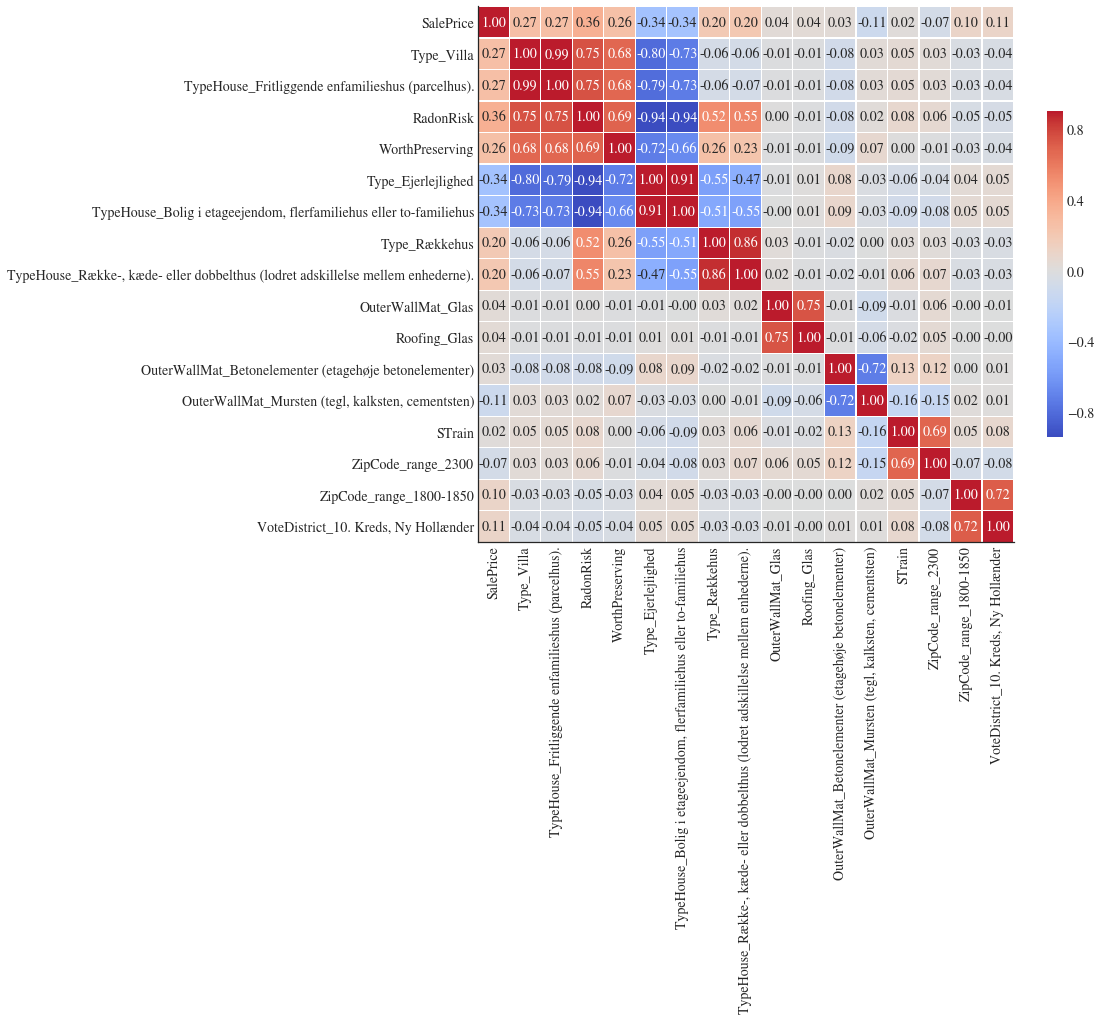

In [24]:
most_corr = ['SalePrice', 'Type_Villa', 'TypeHouse_Fritliggende enfamilieshus (parcelhus).', 'RadonRisk', 'WorthPreserving', 'Type_Ejerlejlighed', 'TypeHouse_Bolig i etageejendom, flerfamiliehus eller to-familiehus', 'Type_Rækkehus', 'TypeHouse_Række-, kæde- eller dobbelthus (lodret adskillelse mellem enhederne).', 
             'OuterWallMat_Glas', 'Roofing_Glas', 
             'OuterWallMat_Betonelementer (etagehøje betonelementer)', 'OuterWallMat_Mursten (tegl, kalksten, cementsten)',
             'STrain', 'ZipCode_range_2300', 
             'ZipCode_range_1800-1850', 'VoteDistrict_10. Kreds, Ny Hollænder'
            ]

plt.rcParams['font.size'] = 14
# HEast map most correlated
corr_dist = df_new_dummies[most_corr].corr(method='spearman')

g_dist = sns.heatmap(corr_dist,  vmax=0.9, center=0, xticklabels=True, yticklabels=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g_dist.figure.set_size_inches(12,12)

plt.show()


In [25]:
df['OuterWallMat'].value_counts()
(df['OuterWallMat'].value_counts()[0] + df['OuterWallMat'].value_counts()[1]) / df['OuterWallMat'].value_counts().sum()


0.9375385132485575

In [26]:
###################################################################
######################## Drop some variables ######################
###################################################################

# Remove Typehouse insted of Type - very correlated
# Radon affects the Type of house - high radn value for villa, low for appartments, remove radon risk
# See correlation between glas wall material and glass roof - makes good sence with a full glasshouse 
# Negative correlation between beton and mursten. df_new['OuterWallMat'].value_counts() Makes good sence since the two categories are overrespesented.
# City variable very correlated with others - eg. city kbh s and s-train, and vote districts and cities. We remove cities since we have a mucher finer division for the city. We can go from district to city but not the other way around.

#VoteDistrict_cols = [col for col in df_new_dummies if col.startswith('VoteDistrict')]
TypeHouse_cols = [col for col in df_new_dummies if col.startswith('TypeHouse')]
#VoteDistrict_cols = [col for col in df_new_dummies if col.startswith('VoteDistrict')]
#ZipCode_cols = [col for col in df_new_dummies if col.startswith('ZipCode')]

df_new_dummies = df_new_dummies.drop(columns=(TypeHouse_cols + ['RadonRisk', 'VoteDistrict_3. Syd']))

# Heat map without correlations
corr_dist = df_new_dummies.corr()
corr_branches_list = (corr_dist.where(np.triu(np.ones(corr_dist.shape), k=1).astype(np.bool))
                      .stack().sort_values(ascending=False))

pd.DataFrame(corr_branches_list)


,,0
OMXC20,PriceIndex,0.865454
Rooms,WeightedFloorArea,0.856489
STrain,ZipCode_range_2300,0.854865
SalePrice,WeightedFloorArea,0.817989
OuterWallMat_Glas,Roofing_Glas,0.748056
ZipCode_range_1800-1850,"VoteDistrict_10. Kreds, Ny Hollænder",0.717028
WorthPreserving,Type_Villa,0.715028
Levels,Type_Rækkehus,0.709729
Rooms,SalePrice,0.699843
ZipCode_range_2400,VoteDistrict_6. Bispebjerg,0.696337


In [27]:
with pd.option_context('display.max_colwidth', -1): 
    display(HTML(df_new_dummies.iloc[:, 16:33].head(100).to_html()))

,School,RoadTrain,Motorway,Daycare,Metro,Doctor,Soccerfield,Hospital,BusStop,Lake,Supermarket,STrain,Airport,Train,Library,PublicBath,Coast
0,747.26,3226.57,2202.27,625.91,2224.95,1237.03,1382.63,4798.33,125.69,3300.62,599.51,657.72,9031.53,2859.07,1561.04,1870.87,245.96
1,747.26,3226.57,2202.27,625.91,2224.95,1237.03,1382.63,4798.33,125.69,3300.62,599.51,657.72,9031.53,2859.07,1561.04,1870.87,245.96
2,747.26,3226.57,2202.27,625.91,2224.95,1237.03,1382.63,4798.33,125.69,3300.62,599.51,657.72,9031.53,2859.07,1561.04,1870.87,245.96
3,691.53,3146.24,2121.94,724.27,2380.62,1156.70,1560.60,4905.10,303.56,3407.39,639.12,835.69,8951.21,3024.04,1480.71,2026.54,86.06
4,691.53,3146.24,2121.94,724.27,2380.62,1156.70,1560.60,4905.10,303.56,3407.39,639.12,835.69,8951.21,3024.04,1480.71,2026.54,86.06
5,691.53,3146.24,2121.94,724.27,2380.62,1156.70,1560.60,4905.10,303.56,3407.39,639.12,835.69,8951.21,3024.04,1480.71,2026.54,86.06
6,677.63,3160.04,2135.75,710.38,2394.53,1170.50,1574.41,4919.01,317.47,3421.20,652.93,849.50,8965.01,3037.85,1494.61,2040.45,72.27
7,677.63,3160.04,2135.75,710.38,2394.53,1170.50,1574.41,4919.01,317.47,3421.20,652.93,849.50,8965.01,3037.85,1494.61,2040.45,72.27
8,677.63,3160.04,2135.75,710.38,2394.53,1170.50,1574.41,4919.01,317.47,3421.20,652.93,849.50,8965.01,3037.85,1494.61,2040.45,72.27
9,677.63,3160.04,2135.75,710.38,2394.53,1170.50,1574.41,4919.01,317.47,3421.20,652.93,849.50,8965.01,3037.85,1494.61,2040.45,72.27


In [28]:
#####################################
##### Remove distance variables #####
#####################################

#df_new_dummies.drop(df_new_dummies.iloc[:, 16:33], inplace = True, axis = 1) 
#df_new_dummies

#df_new_dummies.SalePrice


### ENTITY EMBEDDING

## Transformations

### Target

Skewness: 1.7596235329647705
Kurtosis: 5.507609355454589
Skewness: 0.021769166017049636
Kurtosis: -0.22788926906921603


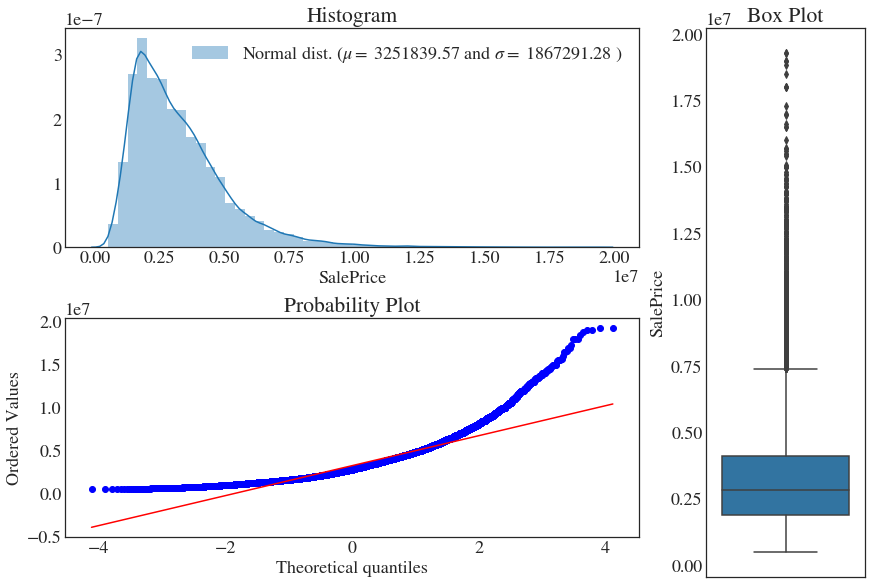

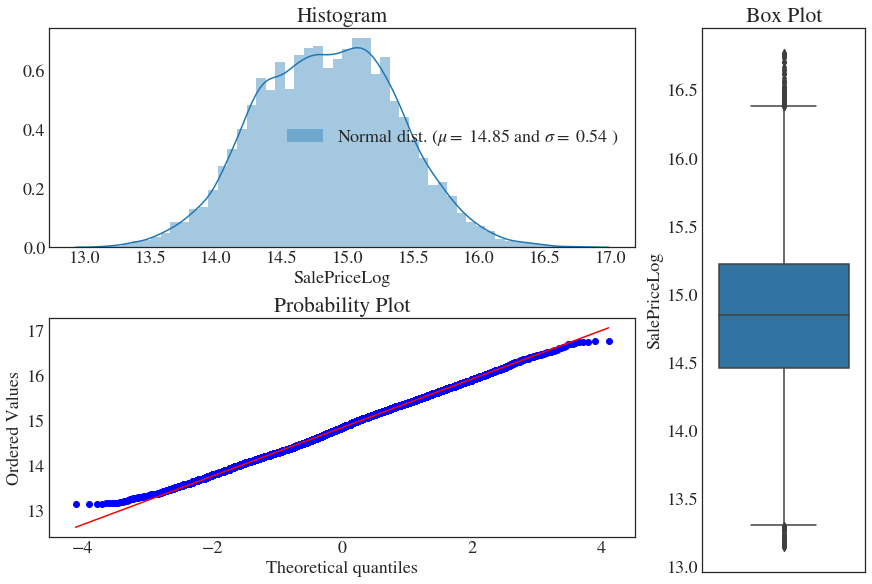

In [29]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    #style.use('seaborn-white')
    plt.rcParams['font.size'] = 18

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df.loc[:,feature])
    #print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], 
               loc='best')

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot', size = 10)
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );


plotting_3_chart(df_new_dummies, 'SalePrice')

#skewness and kurtosis
print("Skewness: " + str(df_new_dummies['SalePrice'].skew()))
print("Kurtosis: " + str(df_new_dummies['SalePrice'].kurt()))


df_new_dummies['SalePriceLog'] = np.log(df_new_dummies.SalePrice)

plotting_3_chart(df_new_dummies, 'SalePriceLog')

#skewness and kurtosis
print("Skewness: " + str(df_new_dummies['SalePriceLog'].skew()))
print("Kurtosis: " + str(df_new_dummies['SalePriceLog'].kurt()))

df_new_dummies = df_new_dummies.drop(columns=['SalePriceLog'])


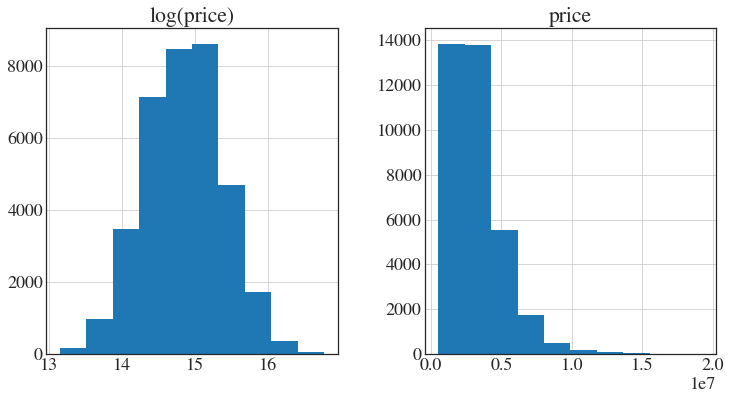

In [30]:
# Print target feature log-transformed 
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df_new_dummies["SalePrice"], "log(price)":np.log(df_new_dummies["SalePrice"])})
prices.hist()
plt.show()

#df_new['SalePrice'] = np.log(df_new["SalePrice"])


### Features

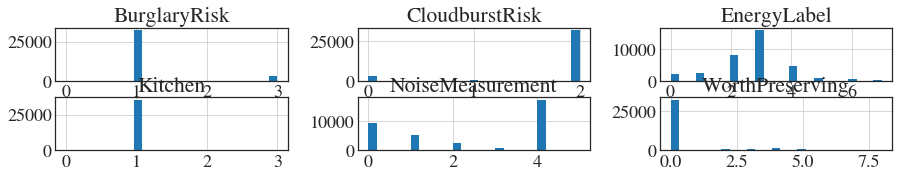

['Kitchen', 'WorthPreserving', 'BurglaryRisk', 'CloudburstRisk']


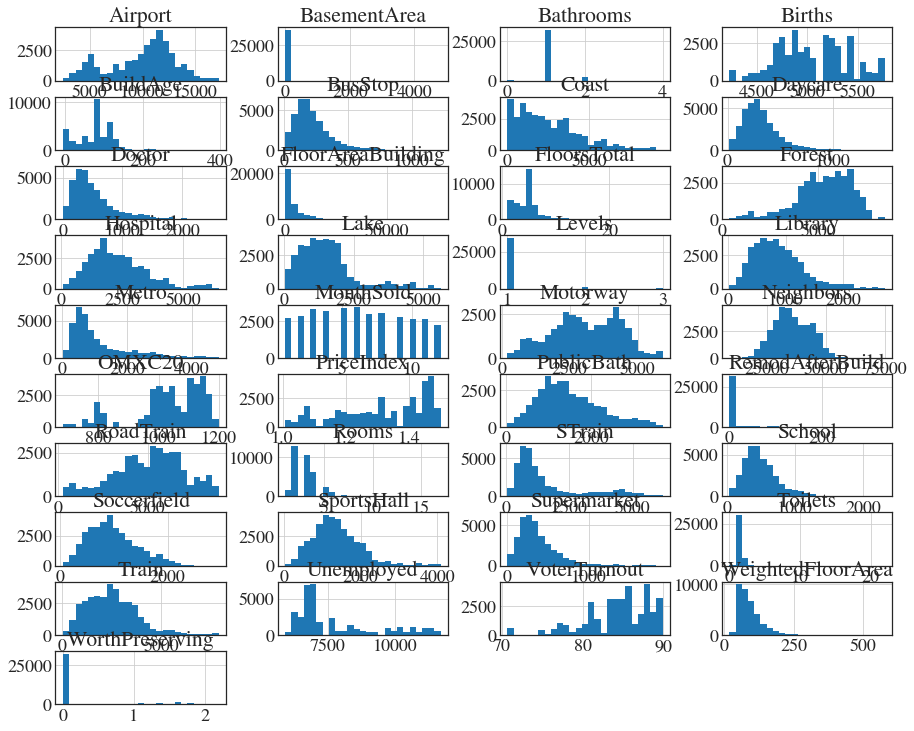

['BasementArea', 'Levels', 'FloorAreaBuilding', 'Toilets', 'RemodAfterBuild', 'WorthPreserving', 'Supermarket', 'School', 'Doctor', 'Bathrooms', 'Daycare', 'WeightedFloorArea', 'FloorsTotal', 'Metro', 'STrain', 'Lake', 'BusStop', 'Rooms', 'Unemployed', 'SportsHall', 'OMXC20']


In [31]:
df_new = df_new_dummies.copy()

df_new['SalePrice'] = np.log(df_new["SalePrice"])

# Fix features with many 0's
#df_new['HasMultipleLevels'] = df_new['Levels'].apply(lambda x: 1 if x > 1 else 0)
#df_new['HasRemodAfterBuild'] = df_new['RemodAfterBuild'].apply(lambda x: 1 if x > 1 else 0)
#df_new['HasBasementArea'] = df_new['BasementArea'].apply(lambda x: 1 if x > 1 else 0)
#df_new['HasHighCloudburstRisk'] = df_new['CloudburstRisk'].apply(lambda x: 1 if (x == 'er høj risiko') else 0)
#df_new['LowBurglaryRisk'] = df_new['BurglaryRisk'].apply(lambda x: 1 if (x == 'lav') else 0)
#df_new['HasOwnKitchen'] = df_new['Kitchen'].apply(lambda x: 1 if (x == 'Eget køkken (med afløb og kogeinstallation)') else 0)
#df_new['IsWorthPreserving'] = df_new['WorthPreserving'].apply(lambda x: 1 if x > 1 else 0)


#df_new = df_new.drop(columns=['Levels', 'RemodAfterBuild', 'BasementArea', 'CloudburstRisk', 'BurglaryRisk', 'Kitchen', 'WorthPreserving'])

# Fix skewness for ordinal features with log +1 tranformation
categorical_ordinal_df_new = df_new.loc[:, df_new.columns.isin(categorical_columns_ordinal)]
# Explore distribution of ordinal columns
categorical_ordinal_df_new.hist(bins=25, layout=(12,3), figsize=(15,15))
plt.show()
skewness = df_new[categorical_ordinal_df_new.columns.tolist()].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_ordi_feats = skewness[abs(skewness) > 1].index.tolist()
print(skewed_ordi_feats)
df_new[skewed_ordi_feats] = np.log1p(df_new[skewed_ordi_feats])


# Fix skewness for numerical features with log +1 tranformation
numerical_df_new = df_new.loc[:, df_new.columns.isin(numerical_cols_df)]
numerical_df_new = numerical_df_new.loc[:, ~numerical_df_new.columns.isin(['SalePrice'])]
# Explore distribution of numeric columns
numerical_df_new.hist(bins=25, layout=(12,4), figsize=(15,15))
plt.show()
skewness = df_new[numerical_df_new.columns.tolist()].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_num_feats = skewness[abs(skewness) > 1].index.tolist()
print(skewed_num_feats)
df_new[skewed_num_feats] = np.log1p(df_new[skewed_num_feats])


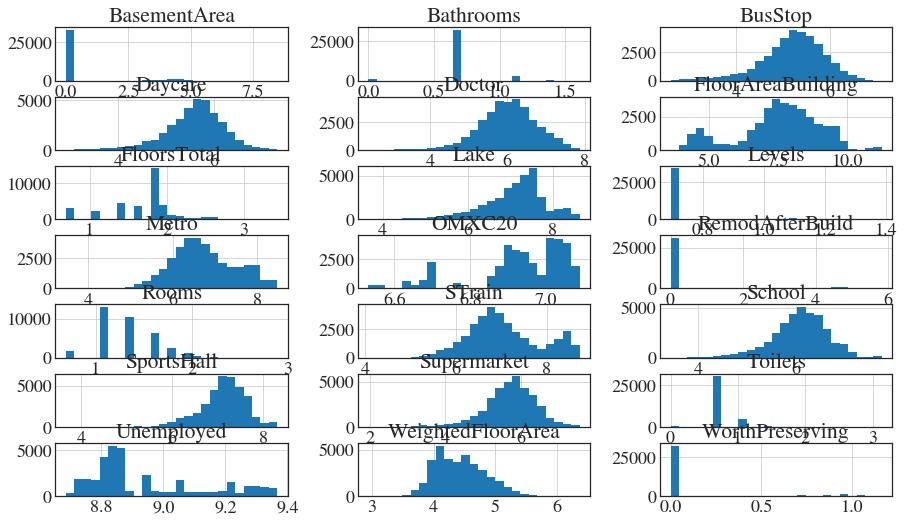

In [32]:
# After tranformation
df_new[skewed_num_feats].hist(bins=25, layout=(12,3), figsize=(15,15))
plt.show()

In [33]:
# Extra
#df_new['ToiletsPerRoom'] = df_new['Toilets'] / df_new['Rooms']
#df_new['ToiletsBathrooms'] = df_new['Toilets'] / df_new['Bathrooms']
#df_new['AvgRoomSize'] = df_new['WeightedFloorArea'] / df_new['Rooms']
#df_new['EstimatedPrice'] = df_new['Neighbors'] * df_new['WeightedFloorArea']

#df_new = df_new.drop(columns=['Rooms'])
#df_new = df_new.reset_index()

#df_new.replace([np.inf, -np.inf], np.nan, inplace=True)


#df_neww = df_new.as_matrix().astype(np.float)
#print(np.any(np.isnan(df_new)))
#print(np.all(np.isfinite(df_neww)))



#df_new.Rooms.describe()

### Rescale

In [34]:
#df_new = df_new[df_new.Type_Ejerlejlighed != 0]


In [35]:
X_new = df_new.drop('SalePrice', axis=1)

#df_new['SaleDateNum'] = pd.to_datetime(y_save['SaleDate'],format='%Y-%m-%d', errors='coerce')
#df_new['SaleDateNum'] = df_new['SaleDateNum'].map(datetime.datetime.toordinal)

# Scale the data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(df_new[X_new.columns.tolist()])

#unique_scaler = preprocessing.StandardScaler()
#unique_scaler.fit(df_new["SalePrice"].values.reshape(-1,1))

df_new[X_new.columns.tolist()] = scaler.transform(df_new[X_new.columns.tolist()])

with pd.option_context('display.max_colwidth', -1): 
    display(HTML(df_new.head(100).to_html()))


,BasementArea,Bathrooms,BurglaryRisk,CloudburstRisk,EnergyLabel,FloorAreaBuilding,FloorsTotal,Kitchen,Levels,NoiseMeasurement,Rooms,SalePrice,Toilets,VoterTurnout,WeightedFloorArea,WorthPreserving,School,RoadTrain,Motorway,Daycare,Metro,Doctor,Soccerfield,Hospital,BusStop,Lake,Supermarket,STrain,Airport,Train,Library,PublicBath,Coast,SportsHall,Forest,OMXC20,Unemployed,Births,BuildAge,RemodAfterBuild,MonthSold,PriceIndex,Neighbors,"HeatSource_Centralvarme fra eget anlæg, et-kammer fyr","HeatSource_Elovne, elpaneler",HeatSource_Fjernvarme/blokvarme (radiatorsystemer el. varmluftanlæg),HeatSource_Gasradiator,HeatSource_Ingen varmeinstallation,"HeatSource_Ovne (kakkelovne, kamin, brændeovne o.l.)",HeatSource_Varmepumpe,LargestParty_enhedslisten,LargestParty_radikale,LargestParty_socialdemokratiet,LargestParty_venstre,ZipCode_range_1100-1200,ZipCode_range_1200-1300,ZipCode_range_1300-1400,ZipCode_range_1400-1450,ZipCode_range_1450-1500,ZipCode_range_1500-1600,ZipCode_range_1600-1700,ZipCode_range_1700-1800,ZipCode_range_1800-1850,ZipCode_range_1850-1900,ZipCode_range_1900-2000,ZipCode_range_2000,ZipCode_range_2100,ZipCode_range_2150,ZipCode_range_2200,ZipCode_range_2300,ZipCode_range_2400,ZipCode_range_2450,ZipCode_range_2500,ZipCode_range_2700,ZipCode_range_2720,ZipCode_range_<1100,OuterWallMat_Andet materiale,OuterWallMat_Betonelementer (etagehøje betonelementer),OuterWallMat_Bindingsværk (med udvendigt synligt træværk),OuterWallMat_Fibercement (asbestfri),OuterWallMat_Glas,"OuterWallMat_Letbeton (lette bloksten, gasbeton)",OuterWallMat_Metalplader,"OuterWallMat_Mursten (tegl, kalksten, cementsten)",OuterWallMat_Plader af fibercement (asbestfri),"OuterWallMat_Plader af fibercement, herunder asbest (eternit el. lign.)",OuterWallMat_Træbeklædning,Type_Ejerlejlighed,Type_Rækkehus,Type_Villa,VoteDistrict_1. Nord,VoteDistrict_1. Nordvest,VoteDistrict_1. Syd,VoteDistrict_1. Vest,VoteDistrict_1. Øst,VoteDistrict_1. Østerbro,"VoteDistrict_10. Kreds, Bülowsvej","VoteDistrict_10. Kreds, Duevej","VoteDistrict_10. Kreds, Ny Hollænder","VoteDistrict_10. Kreds, Søerne","VoteDistrict_11. Kreds, Lindevang","VoteDistrict_11. Kreds, Nyelandsvej","VoteDistrict_11. Kreds, Rådhuset","VoteDistrict_11. Kreds, Søndermark",VoteDistrict_2. Nord,VoteDistrict_2. Sundbyvester,VoteDistrict_2. Syd,VoteDistrict_2. Vest,VoteDistrict_2. Øst,VoteDistrict_3. Indre By,VoteDistrict_3. Nord,VoteDistrict_3. Øst,VoteDistrict_4. Nord,VoteDistrict_4. Sundbyøster,VoteDistrict_4. Syd,VoteDistrict_4. Øst,VoteDistrict_5. Nord,VoteDistrict_5. Nordvest,VoteDistrict_5. Nørrebro,VoteDistrict_5. Nørrebrohallen,VoteDistrict_5. Syd,VoteDistrict_5. Vest,VoteDistrict_5. Øst,VoteDistrict_6. Bispebjerg,VoteDistrict_6. Nord,VoteDistrict_6. Syd,VoteDistrict_6. Vest,VoteDistrict_6. Øst,VoteDistrict_7. Brønshøj,VoteDistrict_7. Katrinedal,VoteDistrict_7. Kirkebjerg,VoteDistrict_7. Nordvest,VoteDistrict_7. Syd,VoteDistrict_7. Vanløse,VoteDistrict_7. Vest,VoteDistrict_7. Øst,VoteDistrict_8. Midt,VoteDistrict_8. Nord,VoteDistrict_8. Syd,VoteDistrict_8. Sydøst,VoteDistrict_8. Valby,VoteDistrict_8. Vest,VoteDistrict_9. Midt,VoteDistrict_9. Nord,VoteDistrict_9. Syd,VoteDistrict_9. Sydhavn,VoteDistrict_9. Vest,VoteDistrict_9. Vesterbro,VoteDistrict_9. Øst,Roofing_Andet materiale,Roofing_Built-up,Roofing_Cementsten,Roofing_Fibercement (asbestfri),"Roofing_Fibercement, herunder asbest (bølge- eller skifer-eternit)",Roofing_Glas,Roofing_Grønne tage,"Roofing_Metalplader (bølgeblik, aluminium, o.lign.)",Roofing_Stråtag,Roofing_Tagpap (med taghældning),Roofing_Tegl
0,-0.29573,-0.115056,-0.269408,0.344042,-1.373335,1.320107,1.024940,-0.02495,-0.194397,0.947260,0.858409,15.149195,-0.314032,0.6294,0.465816,-0.318104,0.956094,-0.969976,-0.691604,1.403708,1.282375,1.498165,0.906085,2.110456,-0.553128,1.351901,1.002812,-0.718261,-0.278160,0.261641,1.569493,0.510174,-1.192269,0.235519,-0.231482,1.248457,-0.619066,-0.168388,-1.436341,-0.381789,1.424636,0.798362,0.704855,-0.064955,-0.08017,0.115375,-0.010585,-0.

### Save

In [36]:
# Merge
df = pd.concat([df_new, y_save, X_save], axis=1)
print(df.shape) 

#df.to_csv('Endeligt data/df_112234engi.csv', index = False)
df.to_csv('Endeligt data/df_modell.csv', index = False)

(35702, 173)


In [37]:
#df = pd.read_csv('Endeligt data/df_1122.csv').iloc[:,1:]

#df

In [38]:
#df = pd.read_csv('Endeligt data/df_model5.csv').iloc[:,1:]
#df.shape
#numeric_feats = df_new_dummies.dtypes[df_new_dummies.dtypes != "object"].index
#numeric_feats = df_new.select_dtypes(include=['float64', 'int64']).index


#skewed_feats = df_new_dummies[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index
#print(skewed_feats)
#df_new_dummies[skewed_feats] = np.log1p(df_new_dummies[skewed_feats])

In [39]:
# lets firs create seperate lists of categorical and numeric columns
#cat_vars = []
#num_vars = []
#for col in df_new.columns.drop("SalePrice"):
#    if df_new[col].dtypes == 'O':
#        cat_vars.append(col)
#    else:
#        num_vars.append(col)

#lets check the lists created.
#print("List of Numeric Columns:",num_vars)
#print("\n")
#print("List of Categorical Columns:",cat_vars)